In [1]:
from time import time
from tqdm import tqdm
from pathlib import Path
from joblib import dump,load

import pandas as pd
import numpy as np
np.random.seed(42)
from scipy.stats import loguniform, powerlaw, uniform, nbinom, randint, boltzmann, binom, beta, halfnorm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, StratifiedKFold, KFold
from sklearn.base import TransformerMixin
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, log_loss
from sklearn.metrics import DetCurveDisplay, PrecisionRecallDisplay, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.calibration import CalibrationDisplay

from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, IsolationForest, VotingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoost, CatBoostClassifier
import lightgbm as lgb #lgb.LGBMClassifier
import xgboost as xgb # xgb.XGBClassifier

### Start

In [2]:
data = pd.read_parquet(Path('data/game_stats.parquet'))
X = data.iloc[:,6:-2]
y = data['home_win'] # target for regression

# Initial Split, this test set will be hold out for scoring
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
features = X_train.columns
print(X_train.shape)
print(X_test.shape)

(1216, 12)
(305, 12)


In [503]:
y.value_counts(normalize=True).round(2), y_train.value_counts(normalize=True).round(2), y_test.value_counts(normalize=True).round(2)

(home_win
 True     0.58
 False    0.42
 Name: proportion, dtype: float64,
 home_win
 True     0.58
 False    0.42
 Name: proportion, dtype: float64,
 home_win
 True     0.58
 False    0.42
 Name: proportion, dtype: float64)

## Contents

*final work is at top, testing work is at bottom*
 - **Imports**
 - **[Data Load, Split](#Start)**
 - **[Final Analysis](#Final-Analysis)** | [Results](#Results) | [Graphs](#Graphical-Evaluation)
   - <font color="green">kNN model would be top choice</font>, *better everything than others except one more false positive*
     - <font color="red">model summary (metrics, parameters) not neatly documented, no model submission file</font> [see results](#Results)
   - direct comparison of top 3 models: kNN, SGD, ExtraTrees, (and [CatBoost informally](#Repeat-with-CatBoost))
     - tried [stacking/blending](#Blending,-Stacking) --> no improvement
       - some merit to kNN+CatBoost+ExtraTrees
   - metrics table and various plots
     - confusion matrix, roc curve, more
 - **[Overall Comparison](#Overall-Comparison)**
   - direct comparison of most models
     - ET, GBR, RF, LGBM, XGB, kNN, SGD
       - *LogReg, Ridge, CatBoost eliminated*
     - tuning notes, metric tables, graphical evaluation
     - overfitting analysis
 - **Could Do**
   - consider more [metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) to provide better model evaluation
     - can look at [final analysis graphs](#Graphical-Evaluation) for ideas     
 - *Test Cells*
   - **[Ensemble Tuning](#Ensemble-Tuning)** and **[Linear+kNN Tuning](#Linear+kNN-Tuning)**
     - briefly determined iterations / grids for models
     - tried optimizing for f1 and roc_auc, f1 typically better results
       - f1 also increased (training CV) roc_auc for most models, resulted in better testing for all models
   - **[Linear+kNN Testing](#Linear+kNN-Testing)**
     - determined feature selection and normalization conditions for linear models
   - **[CatBoost Testing](#CatBoost-Testing)**
     - even after converting to boolean, using `.predict` is wonky
     - better to use `.predict_proba` and then convert result to predictions `[:,1]>=0.5`
     - could repeat tuning effort, then add to *[Ensemble Tuning](#Ensemble-Tuning)* loop

### Final Analysis
 - added section with CatBoost comparison, blends

In [658]:
tuning_grids = {
    'ExtraTreesClassifier': {'iterations': 90, 'grid': {
        'n_estimators':boltzmann(0.01,200,10),  
        'criterion': ['gini'],
    }},
    'KNeighborsClassifier': { 'iterations': 300, 'grid': {
        'n_neighbors': randint(2,9,0), # def=5, 
        'weights': ['uniform','distance'], # def='uniform', weight function used in prediction. uniform or distance based (inverse relation)
        'algorithm': ['ball_tree', 'kd_tree'], # def='auto', brute-force, kd_tree, ball_tree
        'leaf_size': nbinom(20,0.4,1),
        'p':[1,2],
    }},
    'SGDClassifier': { 'iterations': 600, 'grid': {
        'alpha': loguniform(8e-5, 1e-2, 0, 1), # def=1e-4, float | higher values increase regularization strength
        'tol': loguniform(1e-5, 1e-2, 0, 1), # def=1e-3, float or None | convergence parameter
        'eta0': loguniform(1e-2, 8e-1, 0, 1), # def=0.01, float | initial learning rate
        'power_t': powerlaw(1, 0, 1), # def=0.25, float | exponent for invscaling learning rate: eta = eta0/pow(t, power_t)
    }},
}

In [659]:

sgd_pipe = make_pipeline(SelectKBest(score_func=f_classif, k=5), StandardScaler(), 
                         SGDClassifier(random_state=42, max_iter=5000))

knn_pipe = make_pipeline(SelectKBest(score_func=f_classif, k=7), 
                         KNeighborsClassifier(n_jobs=-1))

et_pipe = make_pipeline(StandardScaler(), ExtraTreesClassifier(n_jobs=-1, random_state=42))


In [660]:
%%time

cv_results = pd.DataFrame()
test_results = pd.DataFrame()
final_estimators = []


for pipe in tqdm([et_pipe, sgd_pipe, knn_pipe]): 
    ind = pipe[-1].__class__.__name__
    
    # tuning scores, best model scores
    grid = {f'{ind.lower()}__{key}':val for key,val in tuning_grids[ind]['grid'].items()}
    
    start = time()
    search = RandomizedSearchCV(pipe, grid, n_iter=tuning_grids[ind]['iterations'],
                            scoring='f1', refit=True,  random_state=42, cv=10, n_jobs=-1)
    cv = search.fit(X_train,y_train)
    final_model = cv.best_estimator_
    final_model.fit(X_train,y_train)
    final_estimators.append(final_model)
    y_pred = final_model.predict(X_test).astype(bool)
    stop = round(time()-start,2)

    # tuned testing
    test_results.loc[ind,'precision'] = precision_score(y_test,y_pred)
    test_results.loc[ind,'recall'] = recall_score(y_test,y_pred)   
    test_results.loc[ind,'F1'] = f1_score(y_test,y_pred)
    test_results.loc[ind,'Acc'] = balanced_accuracy_score(y_test,y_pred)
    test_results.loc[ind,'ROCAUC'] = roc_auc_score(y_test,y_pred)
    
    cv = cross_validate(final_model, X_train, y_train,
            scoring=['balanced_accuracy', 'f1', 'roc_auc', 'precision', 'recall'],
                        cv=10, n_jobs=-1)
    # tuned cv results
    cv_results.loc[ind,'precision'] = np.mean(cv['test_precision'])
    cv_results.loc[ind,'recall'] = np.mean(cv['test_recall'])
    cv_results.loc[ind,'F1'] = np.mean(cv['test_f1'])
    cv_results.loc[ind,'Acc'] = np.mean(cv['test_balanced_accuracy'])
    cv_results.loc[ind,'ROCAUC'] = np.mean(cv['test_roc_auc'])




100%|██████████| 3/3 [00:54<00:00, 18.06s/it]

CPU times: total: 19.2 s
Wall time: 54.2 s


#### Results

In [394]:
final_estimators

[Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('extratreesclassifier',
                  ExtraTreesClassifier(n_estimators=109, n_jobs=-1,
                                       random_state=42))]),
 Pipeline(steps=[('selectkbest', SelectKBest(k=5)),
                 ('standardscaler', StandardScaler()),
                 ('sgdclassifier',
                  SGDClassifier(alpha=0.00062036225494805,
                                eta0=0.5307303882737262, max_iter=5000,
                                power_t=0.11119748230615134, random_state=42,
                                tol=0.0003005213373823071))]),
 Pipeline(steps=[('selectkbest', SelectKBest(k=7)),
                 ('kneighborsclassifier',
                  KNeighborsClassifier(algorithm='ball_tree', leaf_size=31,
                                       n_jobs=-1, n_neighbors=8,
                                       weights='distance'))])]

In [425]:
test_results.sort_values('Acc', ascending=False).style\
    .background_gradient(cmap='viridis')\
    .format('{:.3f}')

,precision,recall,F1,Acc,ROCAUC
KNeighborsClassifier,0.949,0.943,0.946,0.937,0.937
ExtraTreesClassifier,0.953,0.926,0.939,0.932,0.932
SGDClassifier,0.953,0.926,0.939,0.932,0.932


In [396]:
cv_results.sort_values('Acc', ascending=False).style\
    .background_gradient(cmap='viridis')\
    .format('{:.3f}')

,precision,recall,F1,Acc,ROCAUC
SGDClassifier,0.936,0.957,0.946,0.934,0.972
KNeighborsClassifier,0.941,0.944,0.942,0.931,0.973
ExtraTreesClassifier,0.927,0.943,0.935,0.921,0.978


#### Graphical Evaluation

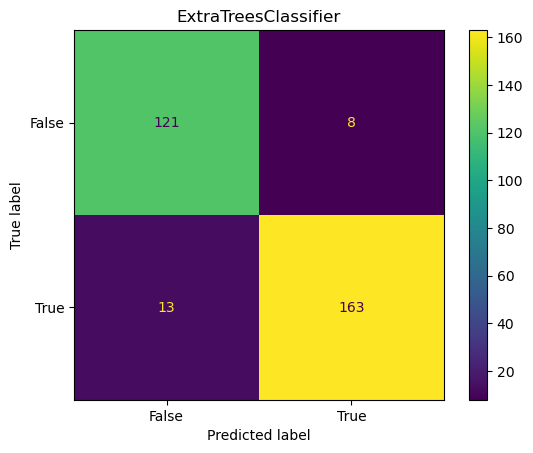

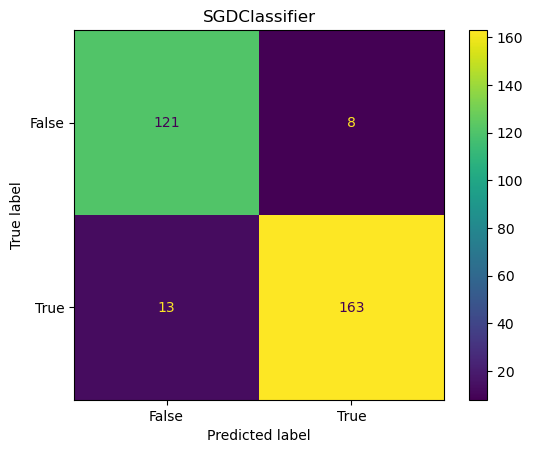

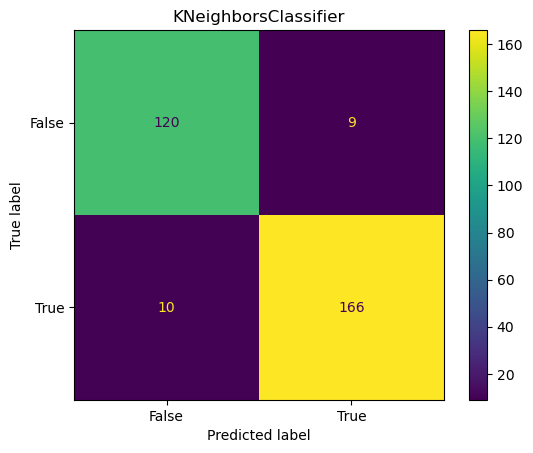

In [505]:
for i in range(len(final_estimators)):
    clf = final_estimators[i]
    name = clf[-1].__class__.__name__
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
    plt.title(name)
    plt.savefig(f'graphs/Model/classification/{name.replace("Classifier","")}_confusion-matrix.png')

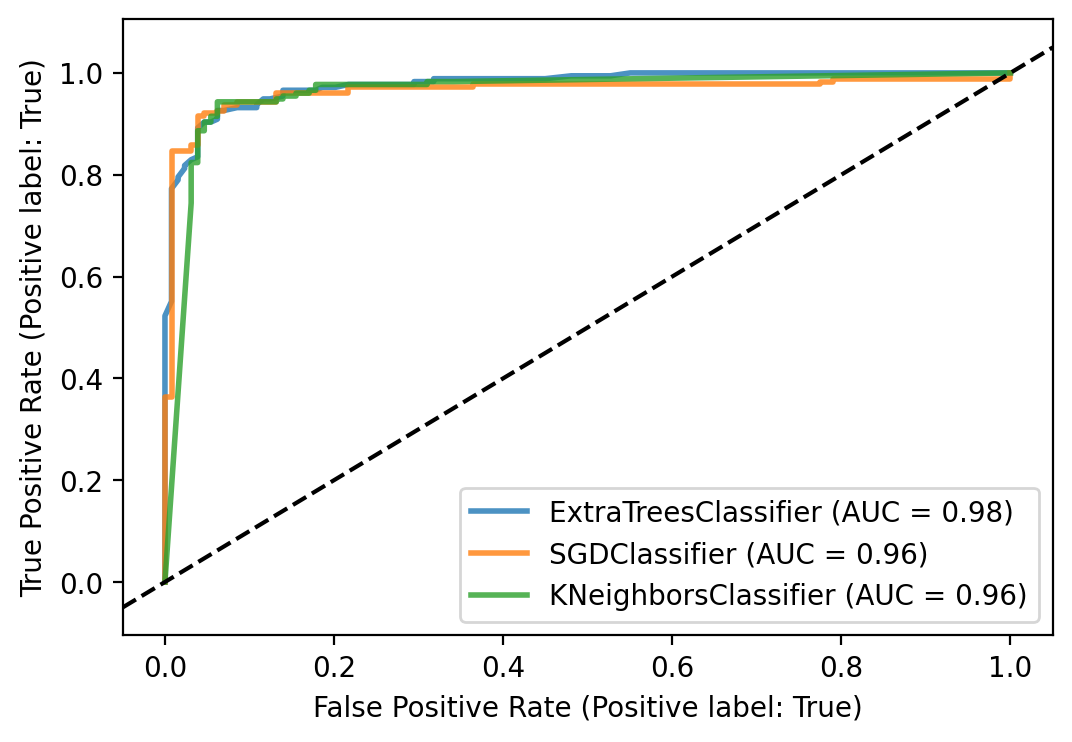

In [514]:
plt.figure(figsize=(6,4), dpi=200)
ax = plt.gca()
curves = {}

for i in range(len(final_estimators)):
    clf = final_estimators[i]
    name = clf[-1].__class__.__name__
    curves[name] = RocCurveDisplay.from_estimator(clf, X_test, y_test, name=name, ax=ax, alpha=0.8, linewidth=2)
xlim = plt.xlim()
plt.plot(xlim, xlim, 'k--')
plt.xlim(xlim)
plt.savefig('graphs/Model/classification/ROC-curve.png', bbox_inches='tight')
plt.show()
#curves[name].plot(ax=ax)

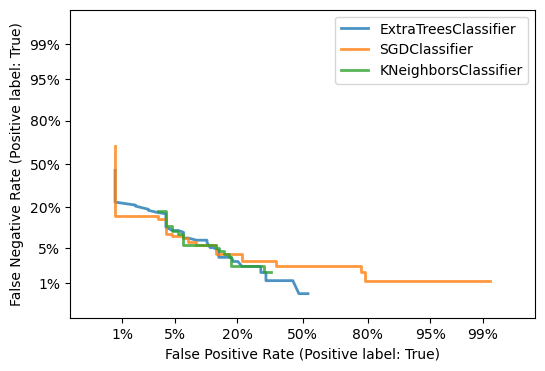

In [513]:
plt.figure(figsize=(6,4), dpi=100)
ax = plt.gca()
curves = {}

for i in range(len(final_estimators)):
    clf = final_estimators[i]
    name = clf[-1].__class__.__name__
    curves[name] = DetCurveDisplay.from_estimator(clf, X_test, y_test, name=name, ax=ax, alpha=0.8, linewidth=2)
# xlim = plt.xlim()
# plt.plot(xlim, xlim, 'k--')
# plt.xlim(xlim)
plt.legend(loc='upper right')
plt.savefig('graphs/Model/classification/DET-curve.png', bbox_inches='tight')
plt.show()
#curves[name].plot(ax=ax)

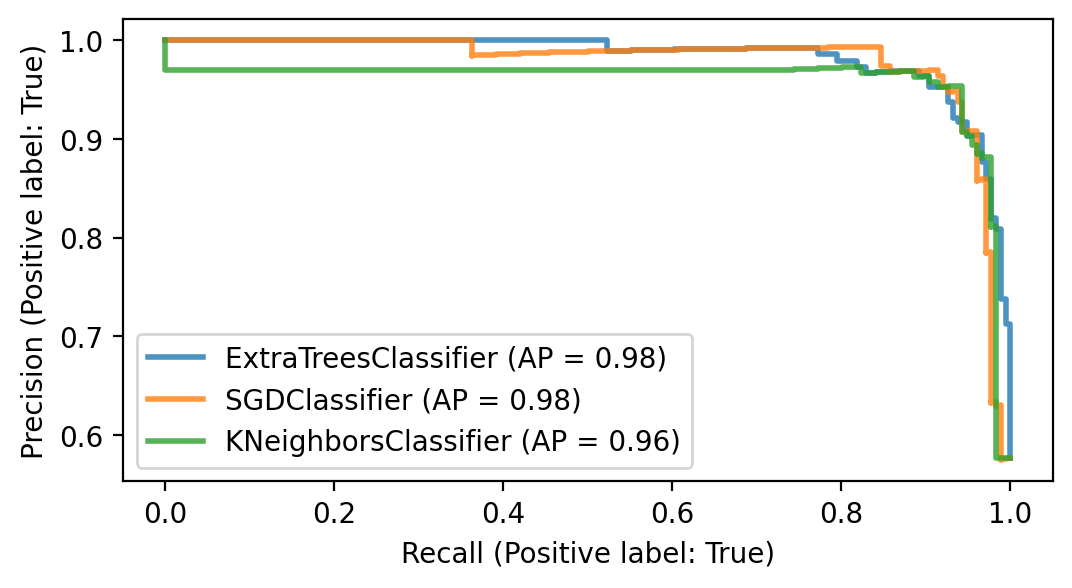

In [511]:
plt.figure(figsize=(6,3), dpi=200)
ax = plt.gca()
curves = {}

for i in range(len(final_estimators)):
    clf = final_estimators[i]
    name = clf[-1].__class__.__name__
    curves[name] = PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, name=name, ax=ax, alpha=0.8, linewidth=2)

plt.savefig('graphs/Model/classification/PR-curve.png', bbox_inches='tight')
plt.show()


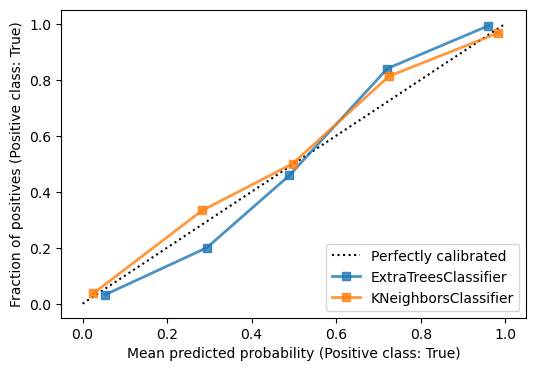

In [510]:
plt.figure(figsize=(6,4), dpi=100)
ax = plt.gca()
curves = {}

for i in range(len(final_estimators)):
    if i == 1:
        continue
    clf = final_estimators[i]
    name = clf[-1].__class__.__name__
    curves[name] = CalibrationDisplay.from_estimator(clf, X_test, y_test, name=name, ax=ax, alpha=0.8, linewidth=2)

plt.savefig('graphs/Model/classification/Calibration-curve.png', bbox_inches='tight')
plt.show()


#### Blending, Stacking

In [424]:
test_results.drop(index=['blend3','stack3'], inplace=True)

In [419]:
blend = VotingClassifier([
    ('knn',final_estimators[2]), ('et',final_estimators[0]), ('sgd',final_estimators[1]),
])
blend.fit(X_train,y_train)
y_pred = blend.predict(X_test)

In [420]:
ind = 'blend3'
test_results.loc[ind,'precision'] = precision_score(y_test,y_pred)
test_results.loc[ind,'recall'] = recall_score(y_test,y_pred)   
test_results.loc[ind,'F1'] = f1_score(y_test,y_pred)
test_results.loc[ind,'Acc'] = balanced_accuracy_score(y_test,y_pred)
test_results.loc[ind,'ROCAUC'] = roc_auc_score(y_test,y_pred)

In [421]:
blend = StackingClassifier([
    ('knn',final_estimators[2]), ('et',final_estimators[0]), ('sgd',final_estimators[1]),
])
blend.fit(X_train,y_train)
y_pred = blend.predict(X_test)

In [422]:
ind = 'stack3'
test_results.loc[ind,'precision'] = precision_score(y_test,y_pred)
test_results.loc[ind,'recall'] = recall_score(y_test,y_pred)   
test_results.loc[ind,'F1'] = f1_score(y_test,y_pred)
test_results.loc[ind,'Acc'] = balanced_accuracy_score(y_test,y_pred)
test_results.loc[ind,'ROCAUC'] = roc_auc_score(y_test,y_pred)

#### Repeat with CatBoost
 - kNN + CatBoost + ExtraTrees blend provides compelling results

In [682]:

for pipe in tqdm([cat_pipe]): 
    ind = pipe[-1].__class__.__name__
  
    pipe.fit(X_train,y_train)
    proba = pipe.predict_proba(X_test)[:,1]
    y_pred = proba >=0.5
    # tuned testing
    test_results.loc[ind,'Acc'] = accuracy_score(y_test,y_pred)
    test_results.loc[ind,'F1'] = f1_score(y_test,y_pred)
    test_results.loc[ind,'ROCAUC'] = roc_auc_score(y_test,proba)
    test_results.loc[ind,'precision'] = precision_score(y_test,y_pred)
    test_results.loc[ind,'recall'] = recall_score(y_test,y_pred)  
    final_estimators.append(pipe)

100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


In [690]:
final_estimators

[Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('extratreesclassifier',
                  ExtraTreesClassifier(n_estimators=109, n_jobs=-1,
                                       random_state=42))]),
 Pipeline(steps=[('selectkbest', SelectKBest(k=5)),
                 ('standardscaler', StandardScaler()),
                 ('sgdclassifier',
                  SGDClassifier(alpha=0.00062036225494805,
                                eta0=0.5307303882737262, max_iter=5000,
                                power_t=0.11119748230615134, random_state=42,
                                tol=0.0003005213373823071))]),
 Pipeline(steps=[('selectkbest', SelectKBest(k=7)),
                 ('kneighborsclassifier',
                  KNeighborsClassifier(algorithm='ball_tree', leaf_size=31,
                                       n_jobs=-1, n_neighbors=8,
                                       weights='distance'))]),
 Pipeline(steps=[('standardscaler', StandardScaler()),
        

In [699]:
blend = VotingClassifier([
    ('knn',final_estimators[2]), ('cat',final_estimators[-1]),('et',final_estimators[0]),
])
blend.fit(X_train,y_train)
y_pred = blend.predict(X_test)

In [700]:
ind = 'kNN+Cat+ET'
test_results.loc[ind,'precision'] = precision_score(y_test,y_pred)
test_results.loc[ind,'recall'] = recall_score(y_test,y_pred)   
test_results.loc[ind,'F1'] = f1_score(y_test,y_pred)
test_results.loc[ind,'Acc'] = balanced_accuracy_score(y_test,y_pred)
test_results.loc[ind,'ROCAUC'] = roc_auc_score(y_test,y_pred)

In [701]:
test_results.sort_values('F1', ascending=False).style\
    .background_gradient(cmap='viridis')\
    .format('{:.3f}')

,precision,recall,F1,Acc,ROCAUC
KNeighborsClassifier,0.949,0.943,0.946,0.937,0.937
kNN+Cat+ET,0.954,0.938,0.946,0.938,0.938
ExtraTreesClassifier,0.953,0.926,0.939,0.932,0.932
SGDClassifier,0.953,0.926,0.939,0.932,0.932
kNN+Cat,0.959,0.920,0.939,0.933,0.933
CatBoostClassifier,0.948,0.926,0.937,0.928,0.972
kNN+Cat+SGD,0.948,0.926,0.937,0.928,0.928


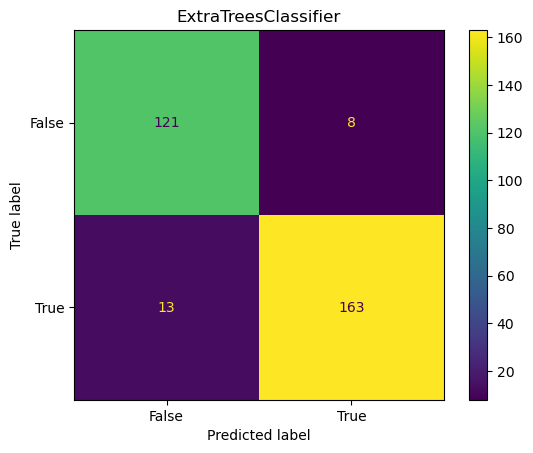

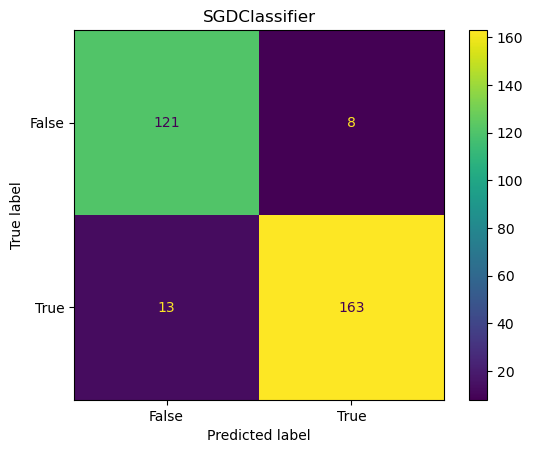

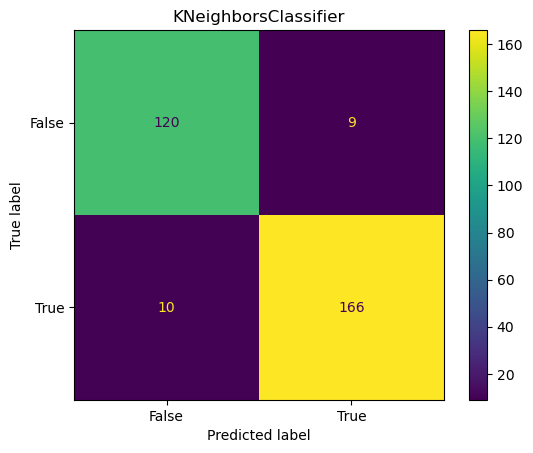

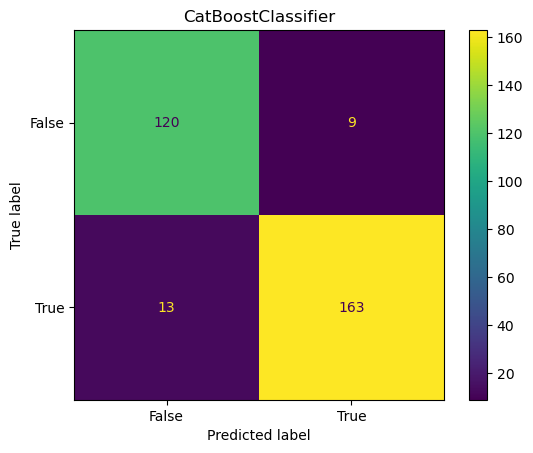

In [679]:
for i in range(len(final_estimators)):
    clf = final_estimators[i]
    name = clf[-1].__class__.__name__
    if name == 'CatBoostClassifier':
        ConfusionMatrixDisplay.from_predictions(y_test,  clf.predict_proba(X_test)[:,1]>=0.5)
    else:
        ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
    plt.title(name)
    #plt.savefig(f'graphs/Model/classification/{name.replace("Classifier","")}_confusion-matrix.png')

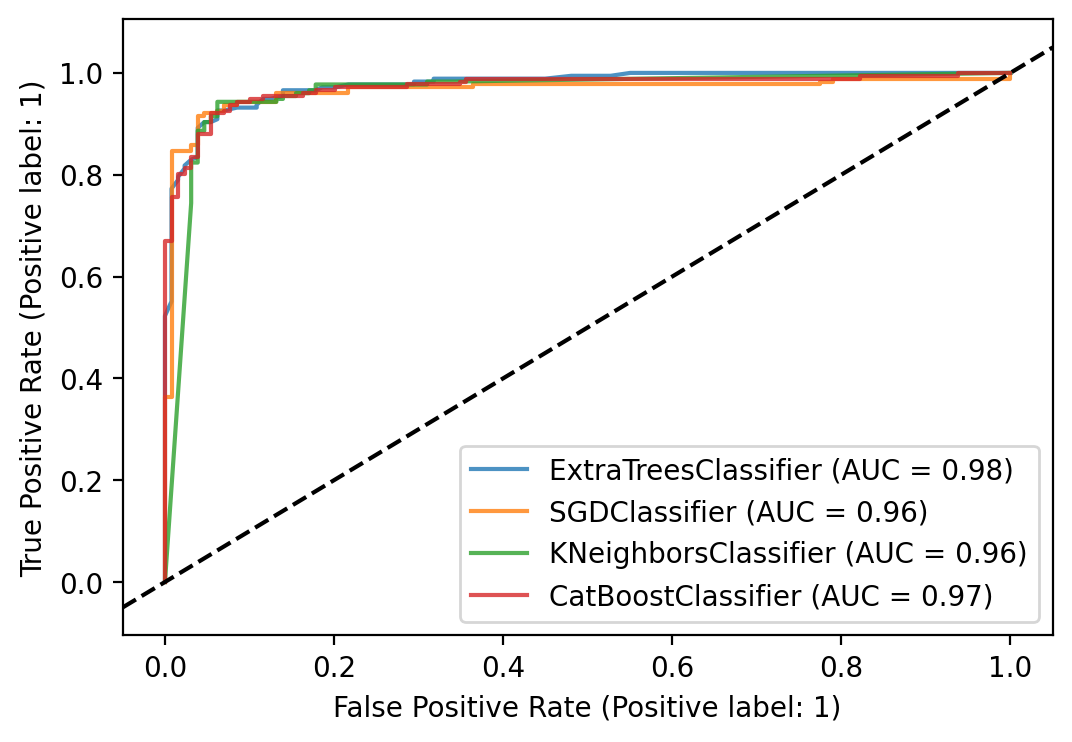

In [672]:
plt.figure(figsize=(6,4), dpi=200)
ax = plt.gca()
curves = {}

for i in range(len(final_estimators)):
    clf = final_estimators[i]
    name = clf[-1].__class__.__name__
    if name == 'CatBoostClassifier':
        curves[name] = RocCurveDisplay.from_predictions(y_test, clf.predict_proba(X_test)[:,1], name=name, ax=ax, alpha=0.8, linewidth=1.5)
    else:
        curves[name] = RocCurveDisplay.from_estimator(clf, X_test, y_test, name=name, ax=ax, alpha=0.8, linewidth=1.5)
xlim = plt.xlim()
plt.plot(xlim, xlim, 'k--')
plt.xlim(xlim)
#plt.savefig('graphs/Model/classification/ROC-curve.png', bbox_inches='tight')
plt.show()
#curves[name].plot(ax=ax)

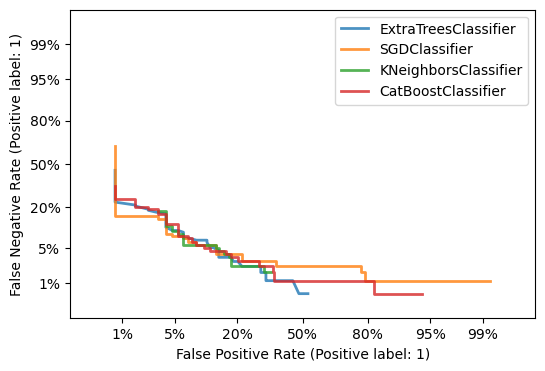

In [680]:
plt.figure(figsize=(6,4), dpi=100)
ax = plt.gca()
curves = {}

for i in range(len(final_estimators)):
    clf = final_estimators[i]
    name = clf[-1].__class__.__name__
    if name == 'CatBoostClassifier':
        curves[name] = DetCurveDisplay.from_predictions(y_test, clf.predict_proba(X_test)[:,1], name=name, ax=ax, alpha=0.8, linewidth=2)
    else:
        curves[name] = DetCurveDisplay.from_estimator(clf, X_test, y_test, name=name, ax=ax, alpha=0.8, linewidth=2)

plt.legend(loc='upper right')
#plt.savefig('graphs/Model/classification/DET-curve.png', bbox_inches='tight')
plt.show()
#curves[name].plot(ax=ax)

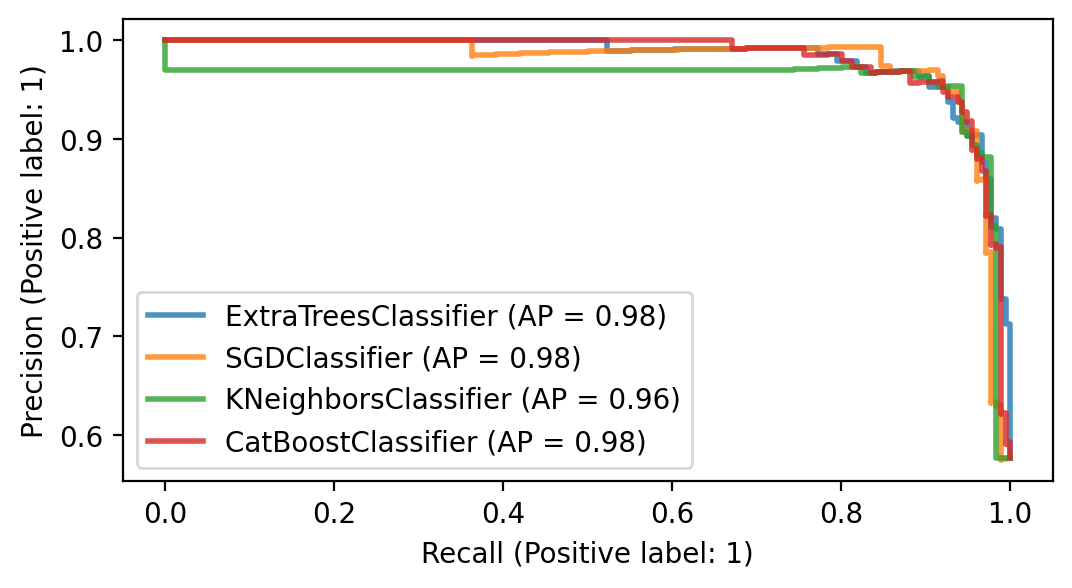

In [681]:
plt.figure(figsize=(6,3), dpi=200)
ax = plt.gca()
curves = {}

for i in range(len(final_estimators)):
    clf = final_estimators[i]
    name = clf[-1].__class__.__name__
    if name == 'CatBoostClassifier':
        curves[name] = PrecisionRecallDisplay.from_predictions(y_test, clf.predict_proba(X_test)[:,1], name=name, ax=ax, alpha=0.8, linewidth=2)
    else:
        curves[name] = PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, name=name, ax=ax, alpha=0.8, linewidth=2)

# plt.savefig('graphs/Model/classification/PR-curve.png', bbox_inches='tight')
plt.show()


### Overall Comparison
 - ensemble have higher ROC-AUC, linear models+kNN have better accuracy

In [651]:
tuning_grids = {
    'ExtraTreesClassifier': {'iterations': 90, 'grid': {
        'n_estimators':boltzmann(0.01,200,10),  
        'criterion': ['gini'],
    }},
    'GradientBoostingClassifier': {'iterations': 60, 'grid': {
        'loss':['exponential'],
        'learning_rate': loguniform(.04,1,0,1),
        'n_estimators': boltzmann(0.01,200,10),
    }},
    'RandomForestClassifier': {'iterations': 60, 'grid': {
        'n_estimators':boltzmann(0.01,200,10), # def=100
        'max_features':binom(9,0.5,1), # def='sqrt' (3-4 out of 12 features)
    }},
    'LGBMClassifier': {'iterations': 120, 'grid': {
        'num_leaves': randint(25,36,0), # def=31
        'min_data_in_leaf': randint(15,25,0),  #def=20, not listed as parameter [min_data, min_data_per_leaf]
        'learning_rate':loguniform(0.01,0.5,0,1), # def=0.1
        'n_estimators':randint(100,300,0), # def=100, not listed as a parameter | boltzmann(0.001,500,50)
    }},
    'XGBClassifier': {'iterations': 60, 'grid': {
        'learning_rate':beta(2,4,0,1), # def=0.3, learning_rate. [0,1]
        'gamma': loguniform(0.001,1,0,1), # def=0, minimum loss reduction, larger=more conservative. [0,inf)
        'max_depth': randint(2,15,0), # def=6, higher increases chances to overfit, use with learning rate
        'subsample': uniform(0.6,0.4), # def=1, (0,1]. practically vary 0.5-1
        'colsample_bytree': uniform(0.6,0.4), # def=1, subsample ratio of columns used when constructing each tree 
    }},
    'KNeighborsClassifier': { 'iterations': 300, 'grid': {
        'n_neighbors': randint(2,9,0), # def=5, 
        'weights': ['uniform','distance'], # def='uniform', weight function used in prediction. uniform or distance based (inverse relation)
        'algorithm': ['ball_tree', 'kd_tree'], # def='auto', brute-force, kd_tree, ball_tree
        'leaf_size': nbinom(20,0.4,1),
        'p':[1,2],
    }},
    'SGDClassifier': { 'iterations': 600, 'grid': {
        'alpha': loguniform(8e-5, 1e-2, 0, 1), # def=1e-4, float | higher values increase regularization strength
        'tol': loguniform(1e-5, 1e-2, 0, 1), # def=1e-3, float or None | convergence parameter
        'eta0': loguniform(1e-2, 8e-1, 0, 1), # def=0.01, float | initial learning rate
        'power_t': powerlaw(1, 0, 1), # def=0.25, float | exponent for invscaling learning rate: eta = eta0/pow(t, power_t)
    }},
}

In [652]:
lr_pipe = make_pipeline(SelectKBest(score_func=f_classif, k=9), StandardScaler(), 
                        LogisticRegression(n_jobs=-1, max_iter=5000, random_state=42))
sgd_pipe = make_pipeline(SelectKBest(score_func=f_classif, k=5), StandardScaler(), 
                         SGDClassifier(random_state=42, max_iter=5000))
ridge_pipe = make_pipeline(SelectKBest(score_func=f_classif, k=6), StandardScaler(), 
                           RidgeClassifier(random_state=42))
knn_pipe = make_pipeline(SelectKBest(score_func=f_classif, k=7), 
                         KNeighborsClassifier(n_jobs=-1))

# ensemble methods - Keep all features
gbr_pipe = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=42, ))
et_pipe = make_pipeline(StandardScaler(), ExtraTreesClassifier(n_jobs=-1, random_state=42))
rf_pipe = make_pipeline(StandardScaler(), RandomForestClassifier(n_jobs=-1, random_state=42))
lgbm_pipe = make_pipeline(StandardScaler(), lgb.LGBMClassifier(n_jobs=-1, random_state=42, verbosity=-1))
xgb_pipe = make_pipeline(StandardScaler(), xgb.XGBClassifier(booster="gbtree", ))
cat_pipe = make_pipeline(StandardScaler(), CatBoostClassifier(random_seed=42, verbose=False))

In [ ]:
%%time

test_results = pd.DataFrame()
cv_results = pd.DataFrame()
tuning_notes = {} # iterations, time taken, best parameters

for pipe in tqdm([lgbm_pipe, xgb_pipe, gbr_pipe, et_pipe, rf_pipe, sgd_pipe, knn_pipe]): 
    ind = pipe[-1].__class__.__name__
    
    # default score: validation set and CV scores
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test).astype(bool)
    cv = cross_validate(pipe, X_train, y_train,
            scoring=['balanced_accuracy', 'f1', 'roc_auc', 'precision', 'recall'],
                        cv=10, n_jobs=-1)

    # cv results
    cv_results.loc[ind,'def_acc'] = np.mean(cv['test_balanced_accuracy'])
    cv_results.loc[ind,'def_F1'] = np.mean(cv['test_f1'])
    cv_results.loc[ind,'def_ROCAUC'] = np.mean(cv['test_roc_auc'])
    cv_results.loc[ind,'def_precision'] = np.mean(cv['test_precision'])
    cv_results.loc[ind,'def_recall'] = np.mean(cv['test_recall'])
    # baseline testing
    test_results.loc[ind,'def_acc'] = balanced_accuracy_score(y_test,y_pred)
    test_results.loc[ind,'def_F1'] = f1_score(y_test,y_pred)
    test_results.loc[ind,'def_ROCAUC'] = roc_auc_score(y_test,y_pred)
    test_results.loc[ind,'def_precision'] = precision_score(y_test,y_pred)
    test_results.loc[ind,'def_recall'] = recall_score(y_test,y_pred)
    
    # tuning scores, best model scores
    grid = {f'{ind.lower()}__{key}':val for key,val in tuning_grids[ind]['grid'].items()}
    
    start = time()
    search = RandomizedSearchCV(pipe, grid, n_iter=tuning_grids[ind]['iterations'],
                            scoring='f1', refit=True,  random_state=42, cv=10, n_jobs=-1)
    cv = search.fit(X_train,y_train)
    y_pred = cv.best_estimator_.predict(X_test).astype(bool)
    stop = round(time()-start,2)
    # record tuning notes
    tuning_notes[ind] = {}
    tuning_notes[ind]['iterations'] = tuning_grids[ind]['iterations']
    tuning_notes[ind]['time'] = stop
    tuning_notes[ind]['parameters'] = cv.best_params_
    
    cv = cross_validate(cv.best_estimator_, X_train, y_train,
            scoring=['balanced_accuracy', 'f1', 'roc_auc', 'precision', 'recall'],
                        cv=10, n_jobs=-1)

    # tuned cv results
    cv_results.loc[ind,'tuned_acc'] = np.mean(cv['test_balanced_accuracy'])
    cv_results.loc[ind,'tuned_F1'] = np.mean(cv['test_f1'])
    cv_results.loc[ind,'tuned_ROCAUC'] = np.mean(cv['test_roc_auc'])
    cv_results.loc[ind,'tuned_precision'] = np.mean(cv['test_precision'])
    cv_results.loc[ind,'tuned_recall'] = np.mean(cv['test_recall'])
    # tuned testing
    test_results.loc[ind,'tuned_acc'] = balanced_accuracy_score(y_test,y_pred)
    test_results.loc[ind,'tuned_F1'] = f1_score(y_test,y_pred)
    test_results.loc[ind,'tuned_ROCAUC'] = roc_auc_score(y_test,y_pred)
    test_results.loc[ind,'tuned_precision'] = precision_score(y_test,y_pred)
    test_results.loc[ind,'tuned_recall'] = recall_score(y_test,y_pred)  
    
    # tune/def test score ratio
    tuning_notes[ind]['factor'] = {
        'F1': cv_results.loc[ind,'tuned_F1'] / cv_results.loc[ind,'def_F1'],
        'ROCAUC' : cv_results.loc[ind,'tuned_ROCAUC'] / cv_results.loc[ind,'def_ROCAUC'],
    }
    


In [656]:

for pipe in tqdm([cat_pipe]): 
    ind = pipe[-1].__class__.__name__
  
    pipe.fit(X_train,y_train)
    y_pred = pipe.predict(X_test).astype(bool)
    proba = pipe.predict_proba(X_test)[:,1]
    # tuned testing
    test_results.loc[ind,'tuned_acc'] = balanced_accuracy_score(y_test,y_pred)
    test_results.loc[ind,'tuned_F1'] = f1_score(y_test,y_pred)
    test_results.loc[ind,'tuned_ROCAUC'] = roc_auc_score(y_test,proba)
    test_results.loc[ind,'tuned_precision'] = precision_score(y_test,y_pred)
    test_results.loc[ind,'tuned_recall'] = recall_score(y_test,y_pred)  

100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


In [312]:
# tuned all models for f1
tuning_notes

{'LGBMClassifier': {'iterations': 120,
  'time': 27.86,
  'parameters': {'lgbmclassifier__learning_rate': 0.020567304765835716,
   'lgbmclassifier__min_data_in_leaf': 21,
   'lgbmclassifier__n_estimators': 226,
   'lgbmclassifier__num_leaves': 33},
  'factor': {'F1': 1.0006033837659005, 'ROCAUC': 1.0010498807444872}},
 'XGBClassifier': {'iterations': 60,
  'time': 9.98,
  'parameters': {'xgbclassifier__colsample_bytree': 0.9588441039810308,
   'xgbclassifier__gamma': 0.45841547801363786,
   'xgbclassifier__learning_rate': 0.2847463196921642,
   'xgbclassifier__max_depth': 7,
   'xgbclassifier__subsample': 0.8675953018856915},
  'factor': {'F1': 1.0143795528814388, 'ROCAUC': 1.0006721861841534}},
 'GradientBoostingClassifier': {'iterations': 60,
  'time': 32.75,
  'parameters': {'gradientboostingclassifier__learning_rate': 0.48040979193832273,
   'gradientboostingclassifier__loss': 'exponential',
   'gradientboostingclassifier__n_estimators': 28},
  'factor': {'F1': 1.0040163948330088, 

In [518]:
test_results[test_results.columns[test_results.columns.str.startswith('tuned')]]\
    .sort_values('tuned_ROCAUC', ascending=False).style\
    .background_gradient(cmap='viridis')\
    .format('{:.3f}')

,tuned_acc,tuned_F1,tuned_ROCAUC,tuned_precision,tuned_recall
KNeighborsClassifier,0.937,0.946,0.937,0.949,0.943
ExtraTreesClassifier,0.932,0.939,0.932,0.953,0.926
SGDClassifier,0.932,0.939,0.932,0.953,0.926
XGBClassifier,0.923,0.931,0.923,0.947,0.915
LGBMClassifier,0.921,0.931,0.921,0.942,0.920
RandomForestClassifier,0.917,0.929,0.917,0.931,0.926
GradientBoostingClassifier,0.910,0.923,0.910,0.926,0.920


In [519]:
cv_results[cv_results.columns[cv_results.columns.str.startswith('tuned')]]\
    .sort_values('tuned_F1', ascending=False).style\
    .background_gradient(cmap='viridis')\
    .format('{:.3f}')

,tuned_acc,tuned_F1,tuned_ROCAUC,tuned_precision,tuned_recall
SGDClassifier,0.934,0.946,0.972,0.936,0.957
KNeighborsClassifier,0.931,0.942,0.973,0.941,0.944
XGBClassifier,0.923,0.936,0.975,0.931,0.942
ExtraTreesClassifier,0.921,0.935,0.978,0.927,0.943
RandomForestClassifier,0.923,0.934,0.978,0.937,0.932
LGBMClassifier,0.918,0.931,0.976,0.930,0.932
GradientBoostingClassifier,0.918,0.931,0.972,0.929,0.933


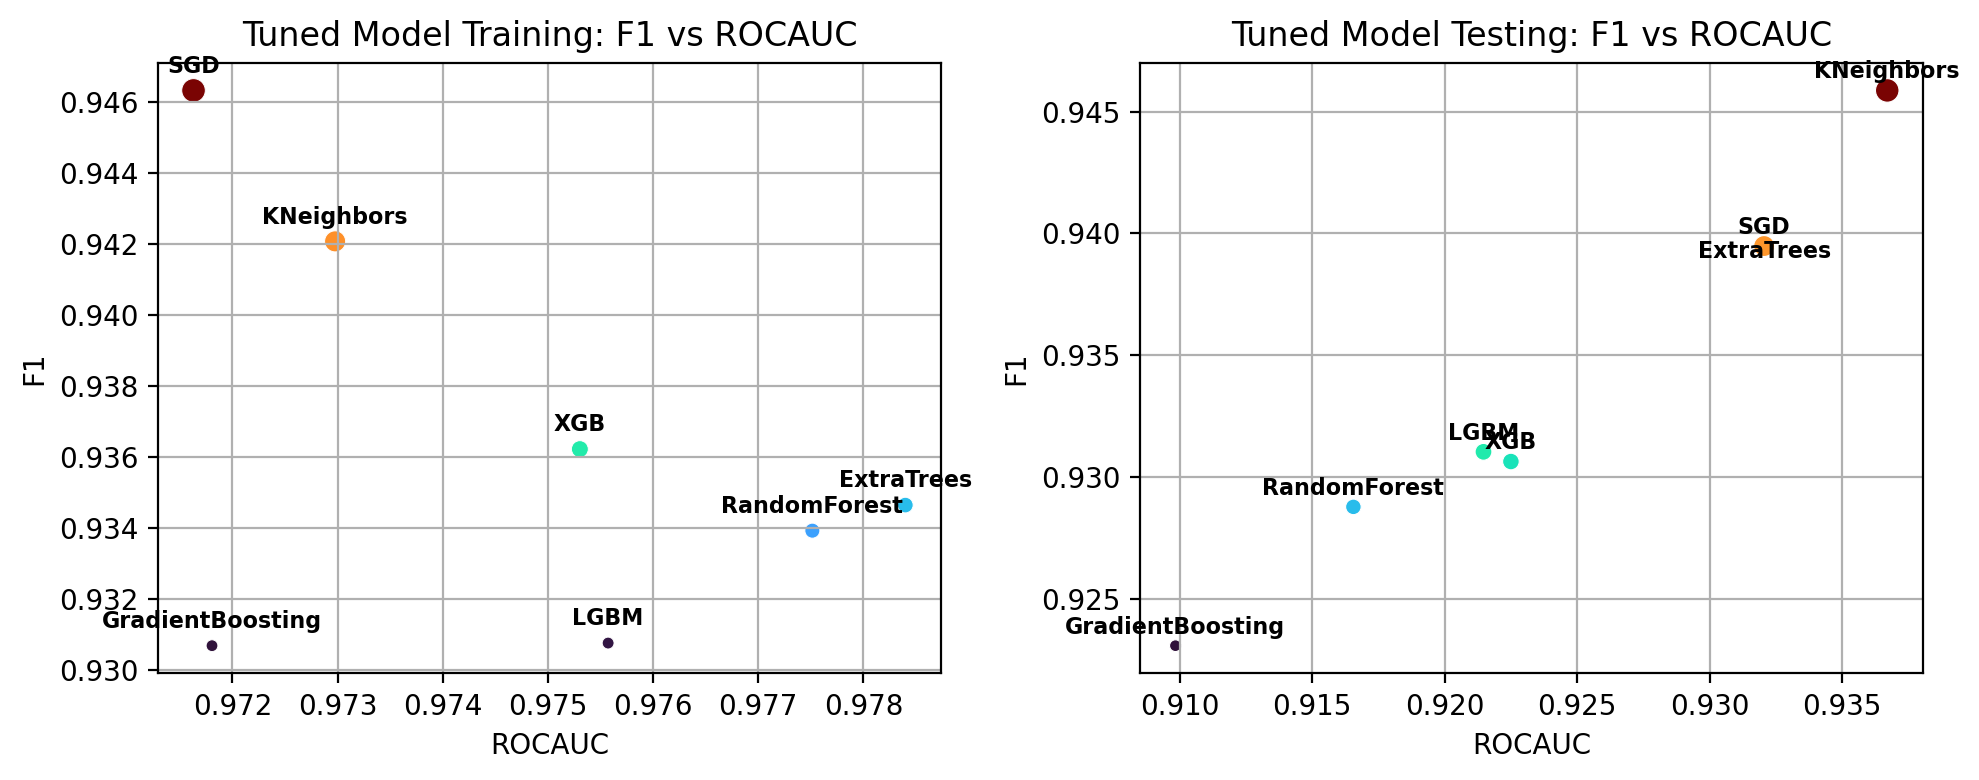

In [523]:
m1 = 'tuned_ROCAUC'
m2 = 'tuned_F1'
m3 = 'tuned_F1'

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), tight_layout=True, dpi=200)


sns.scatterplot(cv_results, x=m1, y=m2, hue=m3, 
                palette='turbo', size=m3, ax=ax1, legend=False)
for val in cv_results.sort_values([m2]).head(7).index:
    ax1.text(cv_results.loc[val,m1], cv_results.loc[val,m2]+.0005,
             val.replace('Classifier',''),
             fontsize=8, fontweight='bold', ha='center')

# ax1.text(cv_results[m1].max()*0.97, cv_results[m2].max()*.98, '| linear models |', 
#          fontsize=8, fontweight='bold', ha='center')

#ax1.legend(loc='upper left', title='R2', frameon=True, facecolor='grey')    
ax1.set_title(f"Tuned Model Training: {m2.replace('tuned_','')} vs {m1.replace('tuned_','')}")
ax1.set_xlabel(m1.replace('tuned_',''))
ax1.set_ylabel(m2.replace('tuned_',''))
ax1.grid()

sns.scatterplot(test_results, x=m1, y=m2, hue=m3, 
                palette='turbo', size=m3, ax=ax2, legend=False)
for val in test_results.sort_values([m2]).head(7).index:
    bump = -.0005 if val == 'ExtraTreesClassifier' else 0.0005
    ax2.text(test_results.loc[val,m1], test_results.loc[val,m2]+bump,
             val.replace('Classifier',''),
             fontsize=8, fontweight='bold', ha='center')

# ax2.text(test_results[m1].max()*0.985, test_results[m2].max()*.98, '| linear models |', 
#          fontsize=8, fontweight='bold', ha='center')

#ax2.legend(loc='upper left', title='R2', frameon=True, facecolor='grey')    
ax2.set_title(f"Tuned Model Testing: {m2.replace('tuned_','')} vs {m1.replace('tuned_','')}")
ax2.set_xlabel(m1.replace('tuned_',''))
ax2.set_ylabel(m2.replace('tuned_',''))
ax2.grid()



plt.savefig(f"graphs/Model/classification/selection/{m2.replace('tuned_','')}-vs-{m1.replace('tuned_','')}.png", bbox_inches='tight')
plt.show()

In [521]:
overfit = pd.DataFrame()
for ind in cv_results.index:
    overfit.loc[ind,'train_F1'] = cv_results.loc[ind,'tuned_F1']
    overfit.loc[ind,'test_F1'] = test_results.loc[ind,'tuned_F1']
    
    overfit.loc[ind,'train_ROCAUC'] = cv_results.loc[ind,'tuned_ROCAUC']
    overfit.loc[ind,'test_ROCAUC'] = test_results.loc[ind,'tuned_ROCAUC']
    
    overfit.loc[ind,'train_Acc'] = cv_results.loc[ind,'tuned_acc']
    overfit.loc[ind,'test_Acc'] = test_results.loc[ind,'tuned_acc']

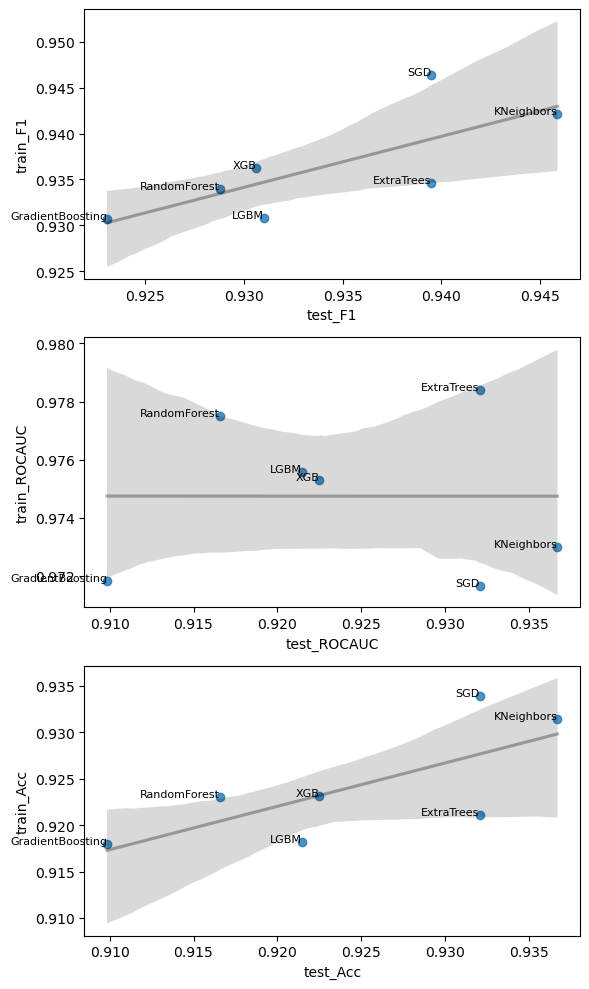

In [522]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(6,10), tight_layout=True, dpi=100)

sns.regplot(overfit, y='train_F1', x='test_F1', ax=ax1, 
            line_kws={'color':'k', 'alpha':0.3})
sns.regplot(overfit, y='train_ROCAUC', x='test_ROCAUC', ax=ax2, 
            line_kws={'color':'k', 'alpha':0.3})
sns.regplot(overfit, y='train_Acc', x='test_Acc', ax=ax3, 
            line_kws={'color':'k', 'alpha':0.3})

for val in overfit.index:
    ax1.text(overfit.loc[val,'test_F1'], overfit.loc[val,'train_F1'], 
             val.replace('Classifier',''), fontsize=8, ha='right')
    ax2.text(overfit.loc[val,'test_ROCAUC'], overfit.loc[val,'train_ROCAUC'],
             val.replace('Classifier',''), fontsize=8, ha='right')
    ax3.text(overfit.loc[val,'test_Acc'], overfit.loc[val,'train_Acc'], 
             val.replace('Classifier',''), fontsize=8, ha='right')

plt.savefig(f'graphs/Model/classification/selection/overfitting_check.png', bbox_inches='tight')


### Ensemble Tuning
 - figure out CatBoost individually, both default and tuning
 - try tuning for F1 and ROC-AUC
   - tuning for F1 somtimes decreases roc-auc (randomforest)
   - tuning for roc-auc usually decreases F1 (not for XGB, GBR)
 - ~~**tuning for ROC-AUC results in better test scores**~~
   - *except GBR!!!*
   - did not hold true with next test. . . 

In [3]:
tuning_grids = {
    # vary estimators, keep criterion at gini, vary min_samples_split?
    'ExtraTreesClassifier': {'iterations': 90, 'grid': {
        'n_estimators':boltzmann(0.01,200,10),  
        'criterion': ['gini'],
    }},
    # vary learning rate, n_estimators. pin down loss function, vary subsample?
    'GradientBoostingClassifier': {'iterations': 60, 'grid': {
        'loss':['exponential'],
        'learning_rate': loguniform(.04,1,0,1),
        'n_estimators': boltzmann(0.01,200,10),
    }},
    'RandomForestClassifier': {'iterations': 60, 'grid': {
        'n_estimators':boltzmann(0.01,200,10), # def=100
        'max_features':binom(9,0.5,1), # def='sqrt' (3-4 out of 12 features)
    }},
    'LGBMClassifier': {'iterations': 120, 'grid': {
        'num_leaves': randint(25,36,0), # def=31
        'min_data_in_leaf': randint(15,25,0),  #def=20, not listed as parameter [min_data, min_data_per_leaf]
        'learning_rate':loguniform(0.01,0.5,0,1), # def=0.1
        'n_estimators':randint(100,300,0), # def=100, not listed as a parameter | boltzmann(0.001,500,50)
    }},
    'CatBoostClassifier': {'iterations': 20, 'grid': {
        'l2_leaf_reg':uniform(0,4), # def=3
        'random_strength':uniform(0,3), # def=1
        'learning_rate':beta(2,20,0,1), # def=0.043
    }},
    # XGB - Tree
    # complexity: max_depth, min_child_weight, gamma
    # randomness: subsample, colsample_bytree. reduce eta while increasing num_round
    'XGBClassifier': {'iterations': 60, 'grid': {
        'learning_rate':beta(2,4,0,1), # def=0.3, learning_rate. [0,1]
        'gamma': loguniform(0.001,1,0,1), # def=0, minimum loss reduction, larger=more conservative. [0,inf)
        'max_depth': randint(2,15,0), # def=6, higher increases chances to overfit, use with learning rate
        'subsample': uniform(0.6,0.4), # def=1, (0,1]. practically vary 0.5-1
        'colsample_bytree': uniform(0.6,0.4), # def=1, subsample ratio of columns used when constructing each tree 
    }},
}

In [4]:
# ensemble methods - Keep all features
gbr_pipe = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=42, ))
et_pipe = make_pipeline(StandardScaler(), ExtraTreesClassifier(n_jobs=-1, random_state=42))
rf_pipe = make_pipeline(StandardScaler(), RandomForestClassifier(n_jobs=-1, random_state=42))
cat_pipe = make_pipeline(StandardScaler(), CatBoostClassifier(random_seed=42, verbose=False))
lgbm_pipe = make_pipeline(StandardScaler(), lgb.LGBMClassifier(n_jobs=-1, random_state=42, verbosity=-1))
xgb_pipe = make_pipeline(StandardScaler(), xgb.XGBClassifier(booster="gbtree", ))

In [16]:
%%time

test_results = pd.DataFrame()
cv_results = pd.DataFrame()
tuning_notes = {} # iterations, time taken, best parameters

for pipe in tqdm([lgbm_pipe, xgb_pipe, gbr_pipe, et_pipe, rf_pipe, cat_pipe]):
    ind = pipe[-1].__class__.__name__
    
    # default score: validation set and CV scores
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:,1] # probability for home win
    y_pred = proba>0.5
    cv = cross_validate(pipe, X_train, y_train,
            scoring=['balanced_accuracy', 'f1', 'roc_auc', 'precision', 'recall'],
                        cv=10, n_jobs=-1)

    # cv results
    cv_results.loc[ind,'def_acc'] = np.mean(cv['test_balanced_accuracy'])
    cv_results.loc[ind,'def_F1'] = np.mean(cv['test_f1'])
    cv_results.loc[ind,'def_ROCAUC'] = np.mean(cv['test_roc_auc'])
    cv_results.loc[ind,'def_precision'] = np.mean(cv['test_precision'])
    cv_results.loc[ind,'def_recall'] = np.mean(cv['test_recall'])
    # baseline testing
    test_results.loc[ind,'def_acc'] = balanced_accuracy_score(y_test,y_pred)
    test_results.loc[ind,'def_F1'] = f1_score(y_test,y_pred)
    test_results.loc[ind,'def_ROCAUC'] = roc_auc_score(y_test,proba)
    test_results.loc[ind,'def_precision'] = precision_score(y_test,y_pred)
    test_results.loc[ind,'def_recall'] = recall_score(y_test,y_pred)
    test_results.loc[ind,'def_log_loss'] = log_loss(y_test,proba)
    
    if ind == 'CatBoostClassifier':
        continue
    # tuning scores, best model scores
    grid = {f'{ind.lower()}__{key}':val for key,val in tuning_grids[ind]['grid'].items()}
    
    start = time()
    search = RandomizedSearchCV(pipe, grid, n_iter=tuning_grids[ind]['iterations'],
                            scoring='f1', refit=True,  random_state=42, cv=10, n_jobs=-1)
    cv = search.fit(X_train,y_train)
    proba = cv.best_estimator_.predict_proba(X_test)[:,1] # probability for home win
    y_pred = proba>0.5
    stop = round(time()-start,2)
    
    # record tuning notes
    tuning_notes[ind] = {}
    tuning_notes[ind]['iterations'] = tuning_grids[ind]['iterations']
    tuning_notes[ind]['time'] = stop
    tuning_notes[ind]['parameters'] = cv.best_params_
    
    cv = cross_validate(cv.best_estimator_, X_train, y_train,
            scoring=['balanced_accuracy', 'f1', 'roc_auc', 'precision', 'recall'],
                        cv=10, n_jobs=-1)

    # tuned cv results
    cv_results.loc[ind,'tuned_acc'] = np.mean(cv['test_balanced_accuracy'])
    cv_results.loc[ind,'tuned_F1'] = np.mean(cv['test_f1'])
    cv_results.loc[ind,'tuned_ROCAUC'] = np.mean(cv['test_roc_auc'])
    cv_results.loc[ind,'tuned_precision'] = np.mean(cv['test_precision'])
    cv_results.loc[ind,'tuned_recall'] = np.mean(cv['test_recall'])
    # tuned testing
    test_results.loc[ind,'tuned_acc'] = balanced_accuracy_score(y_test,y_pred)
    test_results.loc[ind,'tuned_F1'] = f1_score(y_test,y_pred)
    test_results.loc[ind,'tuned_ROCAUC'] = roc_auc_score(y_test,proba)
    test_results.loc[ind,'tuned_precision'] = precision_score(y_test,y_pred)
    test_results.loc[ind,'tuned_recall'] = recall_score(y_test,y_pred)  
    test_results.loc[ind,'tuned_log_loss'] = log_loss(y_test,proba)
    
    # tune/def test score ratio
    tuning_notes[ind]['factor'] = {
        'F1': cv_results.loc[ind,'tuned_F1'] / cv_results.loc[ind,'def_F1'],
        'ROCAUC' : cv_results.loc[ind,'tuned_ROCAUC'] / cv_results.loc[ind,'def_ROCAUC'],
        'LogLoss' : test_results.loc[ind,'tuned_log_loss'] / test_results.loc[ind,'def_log_loss'],
    }
    


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


100%|██████████| 6/6 [02:30<00:00, 25.02s/it]

CPU times: total: 46.2 s
Wall time: 2min 30s


In [17]:
tuning_notes

{'LGBMClassifier': {'iterations': 120,
  'time': 26.56,
  'parameters': {'lgbmclassifier__learning_rate': 0.020567304765835716,
   'lgbmclassifier__min_data_in_leaf': 21,
   'lgbmclassifier__n_estimators': 226,
   'lgbmclassifier__num_leaves': 33},
  'factor': {'F1': 1.0006033837659005,
   'ROCAUC': 1.0010498807444872,
   'LogLoss': 0.7115608161555287}},
 'XGBClassifier': {'iterations': 60,
  'time': 9.78,
  'parameters': {'xgbclassifier__colsample_bytree': 0.9588441039810308,
   'xgbclassifier__gamma': 0.45841547801363786,
   'xgbclassifier__learning_rate': 0.2847463196921642,
   'xgbclassifier__max_depth': 7,
   'xgbclassifier__subsample': 0.8675953018856915},
  'factor': {'F1': 1.0143795528814388,
   'ROCAUC': 1.0006721861841534,
   'LogLoss': 0.8171505572379013}},
 'GradientBoostingClassifier': {'iterations': 60,
  'time': 32.16,
  'parameters': {'gradientboostingclassifier__learning_rate': 0.48040979193832273,
   'gradientboostingclassifier__loss': 'exponential',
   'gradientboost

In [19]:
test_results.sort_values('tuned_F1', ascending=False).style\
    .background_gradient(cmap='viridis')\
    .background_gradient(subset=['tuned_log_loss', 'def_log_loss'], cmap='viridis_r')\
    .format('{:.3f}')

,def_acc,def_F1,def_ROCAUC,def_precision,def_recall,def_log_loss,tuned_acc,tuned_F1,tuned_ROCAUC,tuned_precision,tuned_recall,tuned_log_loss
ExtraTreesClassifier,0.932,0.939,0.976,0.953,0.926,0.206,0.932,0.939,0.977,0.953,0.926,0.206
LGBMClassifier,0.912,0.922,0.967,0.936,0.909,0.321,0.921,0.931,0.970,0.942,0.920,0.229
XGBClassifier,0.915,0.925,0.967,0.936,0.915,0.307,0.923,0.931,0.970,0.947,0.915,0.251
RandomForestClassifier,0.915,0.925,0.974,0.936,0.915,0.207,0.917,0.929,0.974,0.931,0.926,0.203
GradientBoostingClassifier,0.920,0.931,0.972,0.937,0.926,0.212,0.910,0.923,0.961,0.926,0.920,0.318
CatBoostClassifier,0.928,0.937,0.972,0.948,0.926,0.215,nan,nan,nan,nan,nan,nan


In [24]:
cv_results.sort_values('tuned_F1', ascending=False).style\
    .background_gradient(cmap='viridis')\
    .format('{:.3f}')

,def_acc,def_F1,def_ROCAUC,def_precision,def_recall,tuned_acc,tuned_F1,tuned_ROCAUC,tuned_precision,tuned_recall
XGBClassifier,0.909,0.923,0.975,0.922,0.924,0.923,0.936,0.975,0.931,0.942
ExtraTreesClassifier,0.922,0.934,0.978,0.930,0.940,0.921,0.935,0.978,0.927,0.943
RandomForestClassifier,0.920,0.932,0.980,0.934,0.930,0.923,0.934,0.978,0.937,0.932
LGBMClassifier,0.917,0.930,0.975,0.928,0.933,0.918,0.931,0.976,0.930,0.932
GradientBoostingClassifier,0.914,0.927,0.971,0.927,0.927,0.918,0.931,0.972,0.929,0.933
CatBoostClassifier,nan,nan,0.978,nan,nan,nan,nan,nan,nan,nan


### Linear+kNN Tuning
 - models better tuning for f1
 - kNN and SGD outperform Ridge and LogReg

In [633]:
tuning_grids = {
    'SGDClassifier': { 'iterations': 600, 'grid': {
        # leave loss function, penalty, learning_rate, fit_intercept at defaults: 'hinge', 'L2', 'optimal', True
        # vary alpha, tol(erance), eta0, power_t
        'alpha': loguniform(8e-5, 1e-2, 0, 1), # def=1e-4, float | higher values increase regularization strength
        'tol': loguniform(1e-5, 1e-2, 0, 1), # def=1e-3, float or None | convergence parameter
        'eta0': loguniform(1e-2, 8e-1, 0, 1), # def=0.01, float | initial learning rate
        'power_t': powerlaw(1, 0, 1), # def=0.25, float | exponent for invscaling learning rate: eta = eta0/pow(t, power_t)
    }},
    'RidgeClassifier': { 'iterations': 300, 'grid': {
        # vary alpha, tolerance/solver (see old sheet)
        'alpha': loguniform(0.01,10,0,1), # def=1, controls regularization strength [0,inf)
        'tol': loguniform(1e-2,0.95,0,1), # def=1e-4, specifies convergence critieria for solvers: sparse_cg, lsqr, sag, saga, lbfgs
        'solver':['saga', 'lsqr'], # def='auto',
    }},
    'LogisticRegression': { 'iterations': 300, 'grid': {
        # consider separate search to find best solver
        'C': halfnorm(0.01,5), # def=1, inverse of regularization strength (smaller=stronger), must be positive float
        'tol': loguniform(1e-5, 1e-3, 0, 1), # def=1e-4, tolerance for stopping criteria
        'solver': ['lbfgs','saga','liblinear'], # see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_kernels.html
    }},
    'KNeighborsClassifier': { 'iterations': 300, 'grid': {
        # vary n_neighbors, weights, algorithm (k-d vs ball tree), leaf_size (keep default), p [0,1]
        'n_neighbors': randint(2,9,0), # def=5, 
        'weights': ['uniform','distance'], # def='uniform', weight function used in prediction. uniform or distance based (inverse relation)
        'algorithm': ['ball_tree', 'kd_tree'], # def='auto', brute-force, kd_tree, ball_tree
        'leaf_size': nbinom(20,0.4,1),
        'p':[1,2],
    }},
}

In [634]:
lr_pipe = make_pipeline(SelectKBest(score_func=f_classif, k=9), StandardScaler(), 
                        LogisticRegression(n_jobs=-1, max_iter=5000, random_state=42))
sgd_pipe = make_pipeline(SelectKBest(score_func=f_classif, k=5), StandardScaler(), 
                         SGDClassifier(random_state=42, max_iter=5000))
ridge_pipe = make_pipeline(SelectKBest(score_func=f_classif, k=6), StandardScaler(), 
                           RidgeClassifier(random_state=42))
knn_pipe = make_pipeline(SelectKBest(score_func=f_classif, k=7), 
                         KNeighborsClassifier(n_jobs=-1))

In [640]:
%%time

test_results = pd.DataFrame()
cv_results = pd.DataFrame()
tuning_notes = {} # iterations, time taken, best parameters

for pipe in tqdm([sgd_pipe, ridge_pipe, lr_pipe, knn_pipe]):
    ind = pipe[-1].__class__.__name__
    
    # default score: validation set and CV scores
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    cv = cross_validate(pipe, X_train, y_train,
            scoring=['balanced_accuracy', 'f1', 'roc_auc', 'precision', 'recall'],
                        cv=10, n_jobs=-1)

    # cv results
    cv_results.loc[ind,'def_acc'] = np.mean(cv['test_balanced_accuracy'])
    cv_results.loc[ind,'def_F1'] = np.mean(cv['test_f1'])
    cv_results.loc[ind,'def_ROCAUC'] = np.mean(cv['test_roc_auc'])
    cv_results.loc[ind,'def_precision'] = np.mean(cv['test_precision'])
    cv_results.loc[ind,'def_recall'] = np.mean(cv['test_recall'])
    # baseline testing
    test_results.loc[ind,'def_acc'] = balanced_accuracy_score(y_test,y_pred)
    test_results.loc[ind,'def_F1'] = f1_score(y_test,y_pred)
    test_results.loc[ind,'def_ROCAUC'] = roc_auc_score(y_test,y_pred)
    test_results.loc[ind,'def_precision'] = precision_score(y_test,y_pred)
    test_results.loc[ind,'def_recall'] = recall_score(y_test,y_pred)
    
    # tuning scores, best model scores
    grid = {f'{ind.lower()}__{key}':val for key,val in tuning_grids[ind]['grid'].items()}
    
    start = time()
    search = RandomizedSearchCV(pipe, grid, n_iter=tuning_grids[ind]['iterations'],
                            scoring='f1', refit=True,  random_state=42, cv=10, n_jobs=-1)
    cv = search.fit(X_train,y_train)
    y_pred = cv.best_estimator_.predict(X_test)
    stop = round(time()-start,2)
    # record tuning notes
    tuning_notes[ind] = {}
    tuning_notes[ind]['iterations'] = tuning_grids[ind]['iterations']
    tuning_notes[ind]['time'] = stop
    tuning_notes[ind]['parameters'] = cv.best_params_
    
    cv = cross_validate(cv.best_estimator_, X_train, y_train,
            scoring=['balanced_accuracy', 'f1', 'roc_auc', 'precision', 'recall'],
                        cv=10, n_jobs=-1)

    # tuned cv results
    cv_results.loc[ind,'tuned_acc'] = np.mean(cv['test_balanced_accuracy'])
    cv_results.loc[ind,'tuned_F1'] = np.mean(cv['test_f1'])
    cv_results.loc[ind,'tuned_ROCAUC'] = np.mean(cv['test_roc_auc'])
    cv_results.loc[ind,'tuned_precision'] = np.mean(cv['test_precision'])
    cv_results.loc[ind,'tuned_recall'] = np.mean(cv['test_recall'])
    # tuned testing
    test_results.loc[ind,'tuned_acc'] = balanced_accuracy_score(y_test,y_pred)
    test_results.loc[ind,'tuned_F1'] = f1_score(y_test,y_pred)
    test_results.loc[ind,'tuned_ROCAUC'] = roc_auc_score(y_test,y_pred)
    test_results.loc[ind,'tuned_precision'] = precision_score(y_test,y_pred)
    test_results.loc[ind,'tuned_recall'] = recall_score(y_test,y_pred)  
    
    # tune/def test score ratio
    tuning_notes[ind]['factor'] = {
        'F1': cv_results.loc[ind,'tuned_F1'] / cv_results.loc[ind,'def_F1'],
        'ROCAUC' : cv_results.loc[ind,'tuned_ROCAUC'] / cv_results.loc[ind,'def_ROCAUC'],
    }
    


100%|██████████| 2/2 [00:24<00:00, 12.03s/it]

CPU times: total: 10.2 s
Wall time: 24.1 s


In [266]:
tuning_notes

{'SGDClassifier': {'iterations': 600,
  'time': 12.34,
  'parameters': {'sgdclassifier__alpha': 0.00062036225494805,
   'sgdclassifier__eta0': 0.5307303882737262,
   'sgdclassifier__power_t': 0.11119748230615134,
   'sgdclassifier__tol': 0.0003005213373823071},
  'factor': {'F1': 1.0144621234685445, 'ROCAUC': 1.0025743043138151}},
 'RidgeClassifier': {'iterations': 300,
  'time': 6.37,
  'parameters': {'ridgeclassifier__alpha': 6.627897035983006,
   'ridgeclassifier__solver': 'saga',
   'ridgeclassifier__tol': 0.03571848969395598},
  'factor': {'F1': 1.001590094623161, 'ROCAUC': 1.0000307656213945}},
 'LogisticRegression': {'iterations': 300,
  'time': 10.07,
  'parameters': {'logisticregression__C': 0.8365480727678123,
   'logisticregression__solver': 'saga',
   'logisticregression__tol': 0.0006025744092098425},
  'factor': {'F1': 1.0022594682093657, 'ROCAUC': 0.9999149385249728}},
 'KNeighborsClassifier': {'iterations': 300,
  'time': 12.72,
  'parameters': {'kneighborsclassifier__al

In [341]:
print('tuned for roc-auc')
test_results[test_results.columns[test_results.columns.str.startswith('tuned')]].sort_values('tuned_F1', ascending=False).style\
    .background_gradient(cmap='viridis')\
    .format('{:.3f}')

tuned for roc-auc


,tuned_acc,tuned_F1,tuned_ROCAUC,tuned_precision,tuned_recall
SGDClassifier,0.932,0.939,0.932,0.953,0.926
KNeighborsClassifier,0.932,0.939,0.932,0.953,0.926
RidgeClassifier,0.920,0.931,0.920,0.937,0.926
LogisticRegression,0.920,0.931,0.920,0.937,0.926


In [339]:
print('tuned for f1')
test_results[test_results.columns[test_results.columns.str.startswith('tuned')]].sort_values('tuned_F1', ascending=False).style\
    .background_gradient(cmap='viridis')\
    .format('{:.3f}')

tuned for f1


,tuned_acc,tuned_F1,tuned_ROCAUC,tuned_precision,tuned_recall
KNeighborsClassifier,0.937,0.946,0.937,0.949,0.943
SGDClassifier,0.932,0.939,0.932,0.953,0.926
RidgeClassifier,0.916,0.929,0.916,0.927,0.932
LogisticRegression,0.913,0.926,0.913,0.926,0.926


In [254]:
cv_results.sort_values('tuned_F1', ascending=False).style\
    .background_gradient(cmap='viridis')\
    .format('{:.3f}')

,def_acc,def_F1,def_ROCAUC,def_precision,def_recall,tuned_acc,tuned_F1,tuned_ROCAUC,tuned_precision,tuned_recall
SGDClassifier,0.921,0.933,0.969,0.934,0.933,0.934,0.946,0.972,0.936,0.957
KNeighborsClassifier,0.928,0.938,0.966,0.939,0.939,0.931,0.942,0.973,0.941,0.944
LogisticRegression,0.920,0.933,0.972,0.928,0.939,0.923,0.935,0.972,0.931,0.940
RidgeClassifier,0.921,0.933,0.971,0.932,0.935,0.922,0.934,0.971,0.933,0.936


In [259]:
overfit = pd.DataFrame()
for ind in cv_results.index:
    overfit.loc[ind,'train_F1'] = cv_results.loc[ind,'tuned_F1']
    overfit.loc[ind,'test_F1'] = test_results.loc[ind,'tuned_F1']
    
    overfit.loc[ind,'train_ROCAUC'] = cv_results.loc[ind,'tuned_ROCAUC']
    overfit.loc[ind,'test_ROCAUC'] = test_results.loc[ind,'tuned_ROCAUC']
    
    overfit.loc[ind,'train_Acc'] = cv_results.loc[ind,'tuned_acc']
    overfit.loc[ind,'test_Acc'] = test_results.loc[ind,'tuned_acc']

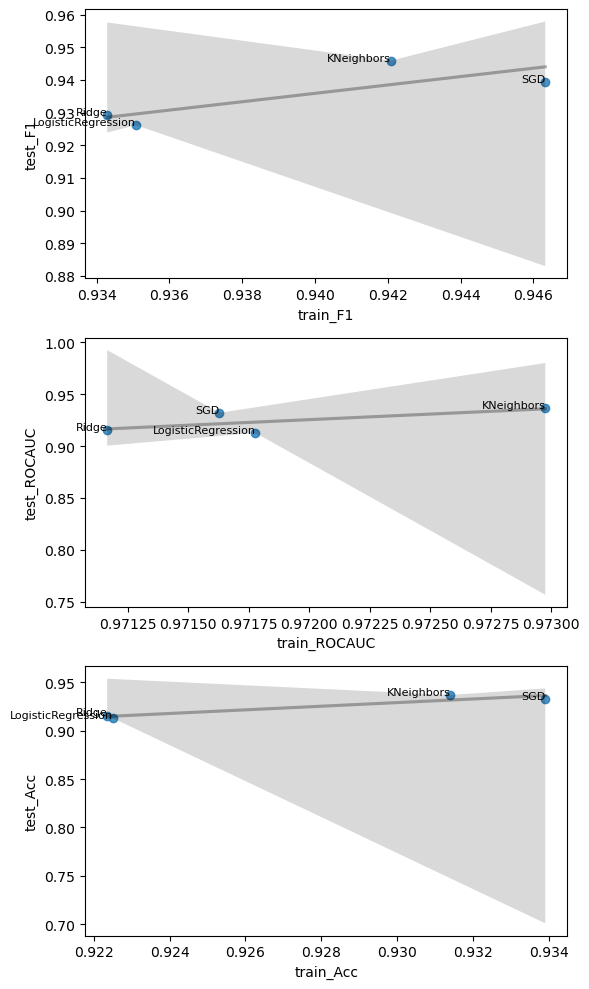

In [262]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(6,10), tight_layout=True, dpi=100)

sns.regplot(overfit, x='train_F1', y='test_F1', ax=ax1, 
            line_kws={'color':'k', 'alpha':0.3})
sns.regplot(overfit, x='train_ROCAUC', y='test_ROCAUC', ax=ax2, 
            line_kws={'color':'k', 'alpha':0.3})
sns.regplot(overfit, x='train_Acc', y='test_Acc', ax=ax3, 
            line_kws={'color':'k', 'alpha':0.3})

for val in overfit.index:
    ax1.text(overfit.loc[val,'train_F1'], overfit.loc[val,'test_F1'], 
             val.replace('Classifier',''), fontsize=8, ha='right')
    ax2.text(overfit.loc[val,'train_ROCAUC'], overfit.loc[val,'test_ROCAUC'], 
             val.replace('Classifier',''), fontsize=8, ha='right')
    ax3.text(overfit.loc[val,'train_Acc'], overfit.loc[val,'test_Acc'], 
             val.replace('Classifier',''), fontsize=8, ha='right')

#plt.savefig(f'graphs/Model/classification/overfitting_check.png', bbox_inches='tight')


### CatBoost Testing
 - scaling better

In [616]:
tuning_grids = {  
    'CatBoostClassifier': {'iterations': 20, 'grid': {
        'l2_leaf_reg':uniform(0,4), # def=3
        'random_strength':uniform(0,3), # def=1
        'learning_rate':beta(2,20,0,1), # def=0.043
    }},
}

In [623]:
cat_pipe = make_pipeline(StandardScaler(), CatBoostClassifier(random_seed=42, verbose=False))

In [624]:
cat_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x0000027CB432F0A0>)])

In [625]:
pred = cat_pipe.predict(X_test).astype(bool)

In [628]:
proba = cat_pipe.predict_proba(X_test)[:,1]

In [631]:
knn_pipe.fit(X_train, y_train)
proba = knn_pipe.predict_proba(X_test)[:,1]

In [ ]:
    ind = 'CatBoostClassifier'
    
    # tuning scores, best model scores
    grid = {f'{ind.lower()}__{key}':val for key,val in tuning_grids[ind]['grid'].items()}
    
    start = time()
    search = RandomizedSearchCV(cat_pipe, grid, n_iter=tuning_grids[ind]['iterations'],
                            scoring='f1', refit=True,  random_state=42, cv=10, n_jobs=-1)
    cv = search.fit(X_train,y_train)
    final_model = cv.best_estimator_
    final_model.fit(X_train,y_train)
    tuned_pred = final_model.predict(X_test).astype(bool)
    tuned_prob = final_model.predict_proba(X_test)[:,1]
    stop = round(time()-start,2)

In [618]:
stop

151.18

In [620]:
final_model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x0000027CBFC4EE60>)])

In [622]:
log_loss(y_test, tuned_prob), roc_auc_score(y_test, tuned_prob), accuracy_score(y_test, tuned_pred)

(0.2608865781341897, 0.9710623678646934, 0.5770491803278689)

In [632]:
log_loss(y_test, proba), roc_auc_score(y_test, proba), accuracy_score(y_test, pred)

(1.1615146731760448, 0.9576286116983791, 0.5770491803278689)

In [610]:
%%time

splits = 10
catboost_results = pd.DataFrame(columns=['acc','f1','roc_auc'])
skf = KFold(n_splits=splits)
i=0

for train,test in tqdm(skf.split(X,y), total=splits):
    cat_pipe.fit(X.iloc[train],y.iloc[train])
    pred = cat_pipe.predict(X.iloc[test]).astype(bool)
    proba = cat_pipe.predict_proba(X.iloc[test])[:,1]
    #catboost_results.loc[i,'p'] = precision_score(y.iloc[test], pred)
    #catboost_results.loc[i,'r'] = recall_score(y.iloc[test], pred)
    catboost_results.loc[i,'f1'] = f1_score(y.iloc[test], pred)
    catboost_results.loc[i,'acc'] = accuracy_score(y.iloc[test], pred)
    catboost_results.loc[i,'roc_auc'] = roc_auc_score(y.iloc[test], proba)
    catboost_results.loc[i,'log_loss'] = log_loss(y.iloc[test], proba)
    i+=1
catboost_results

100%|██████████| 10/10 [00:24<00:00,  2.40s/it]

CPU times: total: 3min 13s
Wall time: 24.1 s


,acc,f1,roc_auc,log_loss
0,0.555556,0.714286,0.852941,0.718572
1,0.578947,0.733333,0.981534,0.166168
2,0.598684,0.748971,0.991533,0.121279
3,0.625,0.769231,0.994829,0.098782
4,0.559211,0.7173,0.982265,0.176013
5,0.565789,0.722689,0.975511,0.210368
6,0.578947,0.733333,0.973366,0.206213
7,0.565789,0.722689,0.981677,0.188855
8,0.565789,0.722689,0.993481,0.109083
9,0.572368,0.728033,0.994872,0.095081


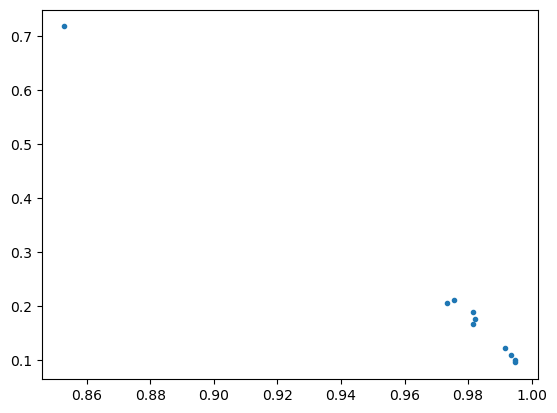

In [615]:
plt.plot(catboost_results['roc_auc'], catboost_results['log_loss'], '.')
plt.show()

In [580]:
%%time

catboost_results = pd.DataFrame(columns=['acc','f1','roc_auc'])
skf = StratifiedKFold(n_splits=4)
i=0

for train,test in tqdm(skf.split(X,y)):
    cat_pipe.fit(X.iloc[train],y.iloc[train])
    pred = cat_pipe.predict(X.iloc[test]).astype(bool)
    catboost_results.loc[i,'p'] = precision_score(y.iloc[test], pred)
    catboost_results.loc[i,'r'] = recall_score(y.iloc[test], pred)
    catboost_results.loc[i,'f1'] = f1_score(y.iloc[test], pred)
    catboost_results.loc[i,'acc'] = balanced_accuracy_score(y.iloc[test], pred)
    catboost_results.loc[i,'roc_auc'] = roc_auc_score(y.iloc[test], pred)
    i+=1

4it [00:09,  2.37s/it]

CPU times: total: 1min 14s
Wall time: 9.49 s


In [584]:
catboost_results.f1.mean()

0.7312965508049225

### Linear+kNN Testing
 - determine best selectk and whether or not to normalize
 - check how well metrics correlate, decide on metric of choice?
   - focus on f1, roc_auc

In [190]:
lr_pipe = make_pipeline(SelectKBest(score_func=f_classif, k=9), StandardScaler(), 
                        LogisticRegression(n_jobs=-1, max_iter=1000, random_state=42))
sgd_pipe = make_pipeline(SelectKBest(score_func=f_classif, k=5), StandardScaler(), 
                         SGDClassifier(random_state=42))
ridge_pipe = make_pipeline(SelectKBest(score_func=f_classif, k=6), StandardScaler(), 
                           RidgeClassifier(random_state=42))
knn_pipe = make_pipeline(SelectKBest(score_func=f_classif, k=7), 
                         KNeighborsClassifier(n_jobs=-1))

In [213]:
r = GridSearchCV(knn_pipe, {'selectkbest__k':range(2,13)}, scoring=['accuracy', 'f1', 'roc_auc', 'precision', 'recall'],
                 refit='accuracy')

In [214]:
%%time
r.fit(X_train,y_train)

CPU times: total: 4.34 s
Wall time: 4.36 s


GridSearchCV(estimator=Pipeline(steps=[('selectkbest', SelectKBest(k=8)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_jobs=-1))]),
             param_grid={'selectkbest__k': range(2, 13)}, refit='accuracy',
             scoring=['accuracy', 'f1', 'roc_auc', 'precision', 'recall'])

In [215]:
rs = pd.DataFrame(r.cv_results_)

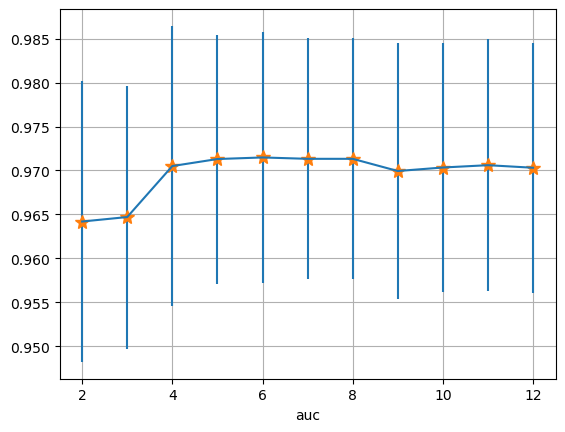

In [204]:
m1 = 'param_selectkbest__k'
m2 = 'mean_test_roc_auc' # mean_test_accuracy, mean_test_f1, mean_test_roc_auc
# mean_test_recall, mean_test_precision

plt.errorbar(rs[m1], rs[m2], yerr=rs[m2.replace('mean','std')])
plt.plot(rs[m1], rs[m2], '*', markersize=10) 
plt.xlabel(m1.split('_')[-1])
plt.xlabel(m2.split('_')[-1])
#plt.xlim([5,9])
plt.grid()

In [216]:
rs[rs.param_selectkbest__k.isin([4,5,6,7,8])].T

,2,3,4,5,6
mean_fit_time,0.010232,0.006247,0.003124,0.002758,0.005572
std_fit_time,0.0085,0.007651,0.006247,0.00307,0.005722
mean_score_time,0.069232,0.069005,0.075122,0.074342,0.074887
std_score_time,0.007314,0.007972,0.006008,0.006582,0.005474
param_selectkbest__k,4,5,6,7,8
params,{'selectkbest__k': 4},{'selectkbest__k': 5},{'selectkbest__k': 6},{'selectkbest__k': 7},{'selectkbest__k': 8}
split0_test_accuracy,0.881148,0.889344,0.905738,0.905738,0.905738
split1_test_accuracy,0.946502,0.942387,0.946502,0.950617,0.946502
split2_test_accuracy,0.950617,0.938272,0.930041,0.930041,0.930041
split3_test_accuracy,0.958848,0.938272,0.946502,0.946502,0.946502
